<a href="https://colab.research.google.com/github/muhammadbabarkamal/Semantic_segmentation_Cityscape/blob/main/A3CVSementicsegmentationMBabarKamal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#All Code

##Data Loading

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [40]:
import os
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
import tensorflow as tf
from tensorflow.keras import layers, Sequential, preprocessing
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomFlip, RandomZoom, RandomRotation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
import PIL
from PIL import ImageOps
!pip install segmentation-models
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

'tf.keras'

In [3]:
files_path = "/content/drive/MyDrive/Colab Notebooks/A3_Dataset/dataset1"

In [4]:
train_label_dir=os.path.join(files_path+'/annotations_prepped_train')
train_image_dir=os.path.join(files_path+'/images_prepped_train')
test_label_dir=os.path.join(files_path+'/annotations_prepped_test')
test_image_dir=os.path.join(files_path+'/images_prepped_test')
#Total Number
print('Total Training Images: ',len(os.listdir(train_image_dir)))
print('Total Training Grouth Truth: ',len(os.listdir(train_label_dir)))
print('Total Test Images: ',len(os.listdir(test_image_dir)))
print('Total Grouth Truth: ',len(os.listdir(test_label_dir)))
train_image = [os.path.join(train_image_dir,fname) for fname in os.listdir(train_image_dir)[:]]
train_label = [os.path.join(train_label_dir,fname) for fname in os.listdir(train_label_dir)[:]]
test_image = [os.path.join(test_image_dir,fname) for fname in os.listdir(test_image_dir)[:]]
test_label = [os.path.join(test_label_dir,fname) for fname in os.listdir(test_label_dir)[:]]
train_image.sort()
train_label.sort()
test_image.sort()
test_label.sort()

Total Training Images:  367
Total Training Grouth Truth:  367
Total Test Images:  101
Total Grouth Truth:  101


In [5]:
from PIL import Image
image_size = (224,224)

#function to load data
def open_image(img):
    return np.array(Image.open(img).resize(image_size, Image.NEAREST))

train_images = np.stack([open_image(i) for i in train_image])
train_labels = np.stack([open_image(i) for i in train_label])
test_images = np.stack([open_image(i) for i in test_image])
test_labels = np.stack([open_image(i) for i in test_label])

print('Train Images Shape: ',train_images.shape)
print('Train labels Shape: ',train_labels.shape)
print('Test Images Shape: ',test_images.shape)
print('Test labels Shape: ',test_labels.shape)

Train Images Shape:  (367, 224, 224, 3)
Train labels Shape:  (367, 224, 224)
Test Images Shape:  (101, 224, 224, 3)
Test labels Shape:  (101, 224, 224)


In [6]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size = 0.25, random_state = 0)
print(X_train.shape)
print(X_val.shape)
y_train=np.expand_dims(y_train, -1)
print(y_train.shape)
y_val=np.expand_dims(y_val, -1)
print(y_val.shape)

(275, 224, 224, 3)
(92, 224, 224, 3)
(275, 224, 224, 1)
(92, 224, 224, 1)


##Data Visulivisation

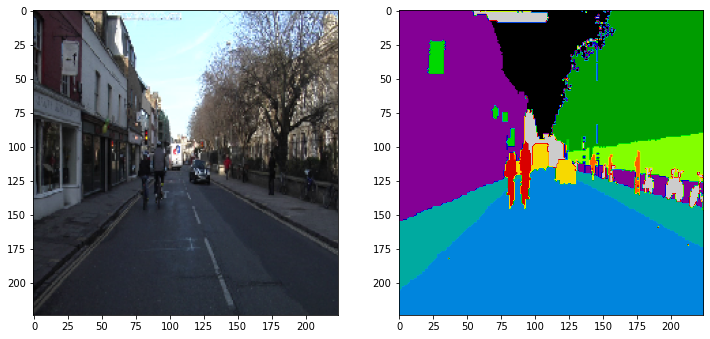

In [ ]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number], cmap='gray')
plt.subplot(122)
plt.imshow(tf.squeeze(y_train[image_number]), cmap='nipy_spectral')
plt.show()

##Data Generator And Augmentation

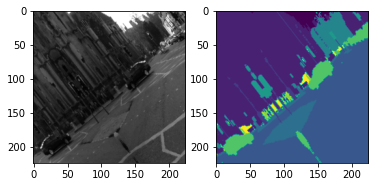

In [7]:
#New generator with rotation and shear where interpolation that comes with rotation and shear are thresholded in masks. 
#This gives a binary mask rather than a mask with interpolated values. 
seed=24
from keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

labels_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect') 

image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(X_train, augment=True, seed=seed)

image_generator = image_data_generator.flow(X_train, seed=seed)
valid_img_generator = image_data_generator.flow(X_val, seed=seed)

mask_data_generator = ImageDataGenerator(**labels_data_gen_args)
mask_data_generator.fit(y_train+(1,), augment=True, seed=seed)
mask_generator = mask_data_generator.flow(y_train, seed=seed)
valid_mask_generator = mask_data_generator.flow(y_val+(1,), seed=seed)

def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

my_generator = my_image_mask_generator(image_generator, mask_generator)

validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)


x = image_generator.next()
y = mask_generator.next()
for i in range(0,1):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()


##U_net with resnet32 for Sementic Segmentation

In [33]:
keras.backend.set_image_data_format('channels_last')
model = sm.Unet('resnet34', encoder_weights='imagenet')
model = sm.Unet('resnet34', classes=12, activation='sigmoid')
model.summary()

85532672/85521592 [==============================] - 2s 0us/step
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_34 (ZeroPadding  (None, None, None,   0          ['bn_data[0][0]']                
 2D)                       

###Traning

In [ ]:
from segmentation_models.metrics import iou_score

# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="Adam", loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score, 'Accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/A3_Dataset/dataset1/City_segmentation3.h5", save_best_only=True)
]

batch_size = 32
steps_per_epoch = 3*(len(X_train))//batch_size


# Train the model, doing validation at the end of each epoch.
epochs = 15
history=model.fit(my_generator, epochs=epochs, validation_data=validation_datagen,steps_per_epoch=steps_per_epoch, validation_steps=steps_per_epoch, callbacks=callbacks)

Epoch 1/15
25/25 [==============================] - 89s 1s/step - loss: -2.5055 - iou_score: 1.3634 - Accuracy: 0.0189 - val_loss: -867.4409 - val_iou_score: 4.0360 - val_Accuracy: 0.7584
Epoch 2/15
25/25 [==============================] - 28s 1s/step - loss: -10.3895 - iou_score: 2.2471 - Accuracy: 0.0024 - val_loss: -1877.8948 - val_iou_score: 4.0870 - val_Accuracy: 0.8974
Epoch 3/15
25/25 [==============================] - 26s 1s/step - loss: -20.7119 - iou_score: 2.5173 - Accuracy: 0.0502 - val_loss: -1740.9738 - val_iou_score: 4.0850 - val_Accuracy: 0.9448
Epoch 4/15
25/25 [==============================] - 25s 1s/step - loss: -31.9602 - iou_score: 2.5947 - Accuracy: 0.1602 - val_loss: -17.9239 - val_iou_score: 2.3547 - val_Accuracy: 0.0444
Epoch 5/15
25/25 [==============================] - 25s 1s/step - loss: -46.1624 - iou_score: 2.7475 - Accuracy: 0.2266 - val_loss: -10.9167 - val_iou_score: 2.3797 - val_Accuracy: 0.0159
Epoch 6/15
25/25 [==============================] - 25s 

In [ ]:
from segmentation_models.metrics import iou_score

# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="Adam", loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score, 'Accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/A3_Dataset/dataset1/City_segmentation3.h5", save_best_only=True)
]

batch_size = 32
steps_per_epoch = 3*(len(X_train))//batch_size


# Train the model, doing validation at the end of each epoch.
epochs = 90
history=model.fit(my_generator, epochs=epochs, validation_data=validation_datagen,steps_per_epoch=steps_per_epoch, validation_steps=steps_per_epoch, callbacks=callbacks)

Epoch 1/90
25/25 [==============================] - 37s 1s/step - loss: -303.6098 - iou_score: 2.9280 - Accuracy: 0.5011 - val_loss: -428.3379 - val_iou_score: 3.5968 - val_Accuracy: 0.5985
Epoch 2/90
25/25 [==============================] - 25s 1s/step - loss: -325.4994 - iou_score: 2.9169 - Accuracy: 0.5102 - val_loss: -352.0483 - val_iou_score: 3.3250 - val_Accuracy: 0.5135
Epoch 3/90
25/25 [==============================] - 28s 1s/step - loss: -347.6824 - iou_score: 2.9137 - Accuracy: 0.5179 - val_loss: -502.5245 - val_iou_score: 3.4306 - val_Accuracy: 0.6253
Epoch 4/90
25/25 [==============================] - 29s 1s/step - loss: -381.4704 - iou_score: 2.9114 - Accuracy: 0.5438 - val_loss: -542.6739 - val_iou_score: 3.4324 - val_Accuracy: 0.6228
Epoch 5/90
25/25 [==============================] - 28s 1s/step - loss: -396.8743 - iou_score: 2.8537 - Accuracy: 0.5515 - val_loss: -586.5276 - val_iou_score: 3.3418 - val_Accuracy: 0.6267
Epoch 6/90
25/25 [==============================] 

###KL Divergence and other parameters

In [34]:
from segmentation_models.metrics import iou_score

# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="Adam", loss=sm.losses.bce_jaccard_loss, metrics=[tf.keras.metrics.KLDivergence(name="kullback_leibler_divergence", dtype=None),tf.keras.metrics.Poisson(name="poisson", dtype=None), 'Accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/A3_Dataset/dataset1/City_segmentation3.h5", save_best_only=True)
]

batch_size = 32
steps_per_epoch = (4)*(len(X_train))//batch_size


# Train the model, doing validation at the end of each epoch.
epochs = 25
history=model.fit(my_generator, epochs=epochs, validation_data=validation_datagen,steps_per_epoch=steps_per_epoch, validation_steps=steps_per_epoch, callbacks=callbacks)

Epoch 1/25
34/34 [==============================] - 50s 1s/step - loss: -1.9965 - kullback_leibler_divergence: 4.9280 - poisson: 1.9428 - Accuracy: 0.0060 - val_loss: -804820.5625 - val_kullback_leibler_divergence: 0.0403 - val_poisson: 1.0132 - val_Accuracy: 0.9999
Epoch 2/25
34/34 [==============================] - 34s 1s/step - loss: -11.0055 - kullback_leibler_divergence: 1.6745 - poisson: 1.1263 - Accuracy: 0.0069 - val_loss: -108714.0391 - val_kullback_leibler_divergence: 0.0023 - val_poisson: 1.0003 - val_Accuracy: 0.9991
Epoch 3/25
34/34 [==============================] - 34s 1s/step - loss: -23.9846 - kullback_leibler_divergence: 3.1540 - poisson: 1.3809 - Accuracy: 0.1562 - val_loss: -56068.5625 - val_kullback_leibler_divergence: 0.1629 - val_poisson: 1.0256 - val_Accuracy: 0.9432
Epoch 4/25
34/34 [==============================] - 33s 992ms/step - loss: -40.9902 - kullback_leibler_divergence: 3.5682 - poisson: 1.4505 - Accuracy: 0.2704 - val_loss: -67077.6016 - val_kullback_

###Model Analysis

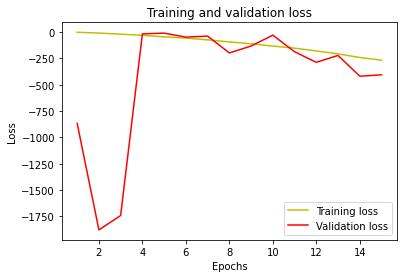

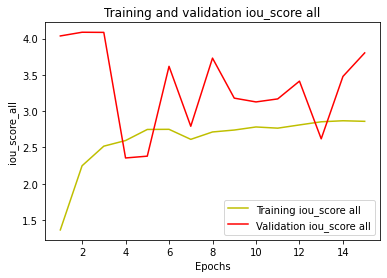

IoU socre is:  0.8410473394520852


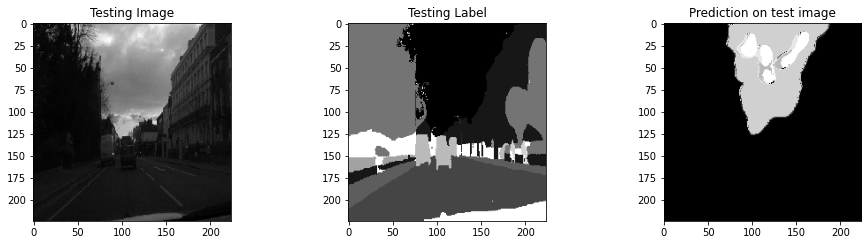

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#acc = history.history['accuracy']
#val_acc = history.history['val_accuracy']

#plt.plot(epochs, acc, 'y', label='Training acc')
#plt.plot(epochs, val_acc, 'r', label='Validation acc')
#plt.title('Training and validation accuracy')
#plt.xlabel('Epochs')
#plt.ylabel('Accuracy')
#plt.legend()
#plt.show()

iou_scoreall = history.history['iou_score']
val_iou_scoreall = history.history['val_iou_score']

plt.plot(epochs, iou_scoreall, 'y', label='Training iou_score all')
plt.plot(epochs, val_iou_scoreall, 'r', label='Validation iou_score all')
plt.title('Training and validation iou_score all')
plt.xlabel('Epochs')
plt.ylabel('iou_score_all')
plt.legend()
plt.show()

#IOU
y_pred=model.predict(X_val)
y_pred_thresholded = y_pred > 0.5
#print("validation accuracy",y_pred[1])

intersection = np.logical_and(y_val, y_pred_thresholded)
union = np.logical_or(y_val, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

#Predict on a few images
#model = get_model()
#model.load_weights('mitochondria_50_plus_100_epochs.hdf5') #Trained for 50 epochs and then additional 100

test_img_number = random.randint(0, len(X_val))
test_img = X_val[3]
ground_truth=y_val[3]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(X_val))

mask = np.argmax(prediction[3], axis=-1)
mask = np.expand_dims(mask, axis=-1)
img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))



plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(img, cmap='gray')

plt.show()

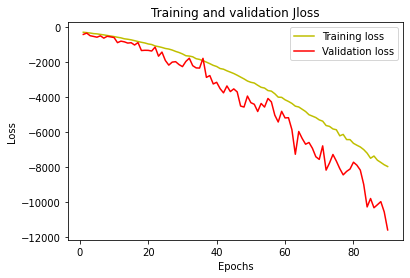

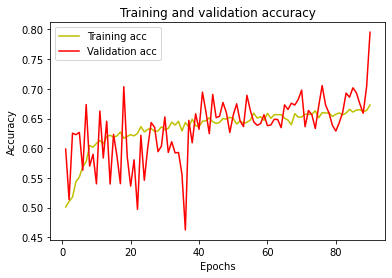

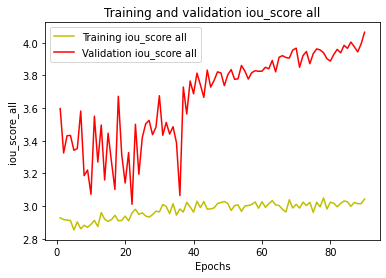

IoU socre is:  0.8410473394520852


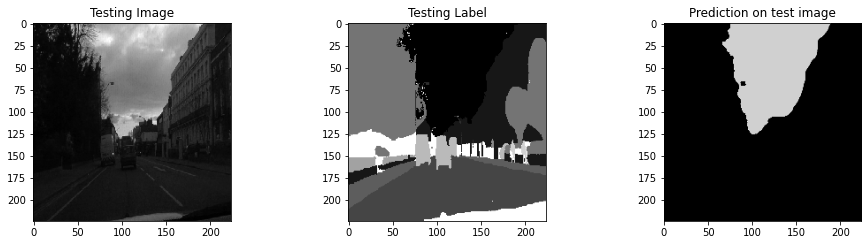

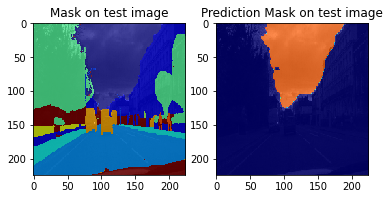

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation Jloss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['Accuracy']
val_acc = history.history['val_Accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

iou_scoreall = history.history['iou_score']
val_iou_scoreall = history.history['val_iou_score']

plt.plot(epochs, iou_scoreall, 'y', label='Training iou_score all')
plt.plot(epochs, val_iou_scoreall, 'r', label='Validation iou_score all')
plt.title('Training and validation iou_score all')
plt.xlabel('Epochs')
plt.ylabel('iou_score_all')
plt.legend()
plt.show()

#IOU
y_pred=model.predict(X_val)
y_pred_thresholded = y_pred > 0.5
#print("validation accuracy",y_pred[1])

intersection = np.logical_and(y_val, y_pred_thresholded)
union = np.logical_or(y_val, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

#Predict on a few images
#model = get_model()
#model.load_weights('mitochondria_50_plus_100_epochs.hdf5') #Trained for 50 epochs and then additional 100

test_img_number = random.randint(0, len(X_val))
test_img = X_val[3]
ground_truth=y_val[3]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(X_val))

mask = np.argmax(prediction[3], axis=-1)
mask = np.expand_dims(mask, axis=-1)
img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))



plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(img, cmap='gray')

plt.show()
plt.figure()
plt.subplot(1,2,1)
plt.imshow(test_img[:,:,0], 'gray', interpolation='none')
plt.imshow(ground_truth[:,:,0], 'jet', interpolation='none', alpha=0.7)
plt.title('Mask on test image')
plt.subplot(1,2,2)
plt.imshow(test_img[:,:,0], 'gray', interpolation='none')
plt.imshow(img, 'jet', interpolation='none', alpha=0.7)
plt.title('Prediction Mask on test image')
plt.show()

KLdiv & possioum

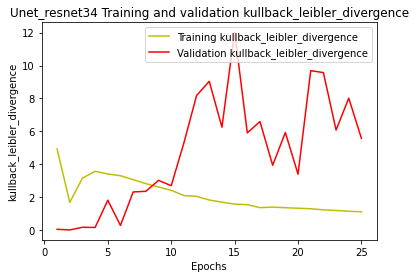

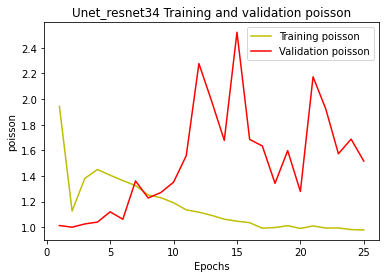

IoU socre is:  0.6185911346005795


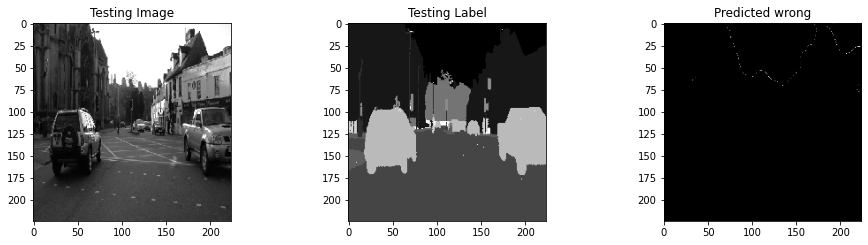

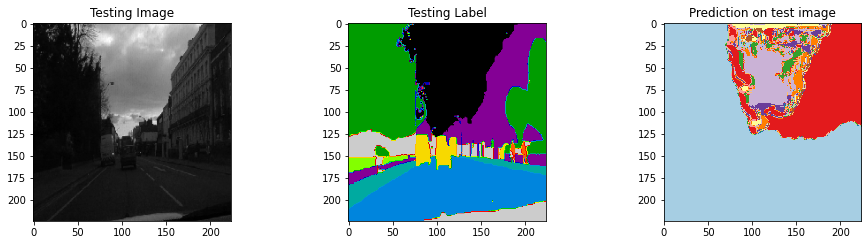

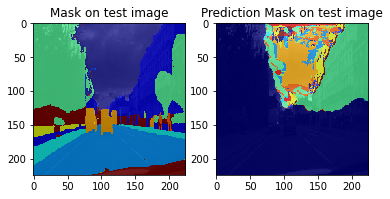

In [43]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['kullback_leibler_divergence']
val_loss = history.history['val_kullback_leibler_divergence']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training kullback_leibler_divergence')
plt.plot(epochs, val_loss, 'r', label='Validation kullback_leibler_divergence')
plt.title('Unet_resnet34 Training and validation kullback_leibler_divergence')
plt.xlabel('Epochs')
plt.ylabel('kullback_leibler_divergence')
plt.legend()
plt.show()

acc = history.history['poisson']
val_acc = history.history['val_poisson']

plt.plot(epochs, acc, 'y', label='Training poisson')
plt.plot(epochs, val_acc, 'r', label='Validation poisson')
plt.title('Unet_resnet34 Training and validation poisson')
plt.xlabel('Epochs')
plt.ylabel('poisson')
plt.legend()
plt.show()


#IOU
y_pred=model.predict(X_val)
y_pred_thresholded = y_pred > 0.9
y_pred_thresholdedL = y_pred < 0.45

test_img = X_val[1]
ground_truth=y_val[1]
wrongly= y_pred_thresholdedL[1]
mask = np.argmax(wrongly, axis=-1)
mask = np.expand_dims(mask, axis=-1)
imgw = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Predicted wrong')
plt.imshow(imgw, cmap='gray')


#print("validation accuracy",y_pred[1])

intersection = np.logical_and(y_val, y_pred_thresholded)
union = np.logical_or(y_val, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

#Predict on a few images
#model = get_model()
#model.load_weights('mitochondria_50_plus_100_epochs.hdf5') #Trained for 50 epochs and then additional 100

#test_img_number = random.randint(0, len(X_val))
test_img = X_val[3]
ground_truth=y_val[3]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(X_val))

mask = np.argmax(prediction[3], axis=-1)
mask = np.expand_dims(mask, axis=-1)
img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))



plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='nipy_spectral')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(img, cmap='Paired')

plt.show()
plt.figure()
plt.subplot(1,2,1)
plt.imshow(test_img[:,:,0], 'gray', interpolation='none')
plt.imshow(ground_truth[:,:,0], 'jet', interpolation='none', alpha=0.7)
plt.title('Mask on test image')
plt.subplot(1,2,2)
plt.imshow(test_img[:,:,0], 'gray', interpolation='none')
plt.imshow(img, 'jet', interpolation='none', alpha=0.7)
plt.title('Prediction Mask on test image')
plt.show()

## Unet with MobileNet V2 For Sementic segmentation

In [17]:
BACKBONE = 'mobilenetv2'
preprocess_input = sm.get_preprocessing(BACKBONE)
keras.backend.set_image_data_format('channels_last')
# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=12, activation='sigmoid')
model.summary()

/usr/local/lib/python3.7/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['Conv1_pad[0][0]']              
                                32)                                                           

###Traning

In [ ]:
from segmentation_models.metrics import iou_score

# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="Adam", loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score, 'Accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/A3_Dataset/dataset1/City_segmentation4.h5", save_best_only=True)
]

batch_size = 32
steps_per_epoch = (4)*(len(X_train))//batch_size


# Train the model, doing validation at the end of each epoch.
epochs = 40
history=model.fit(my_generator, epochs=epochs, validation_data=validation_datagen,steps_per_epoch=steps_per_epoch, validation_steps=steps_per_epoch, callbacks=callbacks)

Epoch 1/40
34/34 [==============================] - 34s 872ms/step - loss: -52.3938 - iou_score: 2.3440 - Accuracy: 0.2690 - val_loss: -31.1897 - val_iou_score: 2.4099 - val_Accuracy: 0.0537
Epoch 2/40
34/34 [==============================] - 28s 843ms/step - loss: -70.5761 - iou_score: 2.4296 - Accuracy: 0.2907 - val_loss: -64.2322 - val_iou_score: 3.7558 - val_Accuracy: 0.3391
Epoch 3/40
34/34 [==============================] - 27s 791ms/step - loss: -89.0362 - iou_score: 2.4167 - Accuracy: 0.3172 - val_loss: -49.4979 - val_iou_score: 3.2956 - val_Accuracy: 0.3137
Epoch 4/40
34/34 [==============================] - 27s 815ms/step - loss: -109.0014 - iou_score: 2.5326 - Accuracy: 0.3510 - val_loss: -10.1037 - val_iou_score: 1.7723 - val_Accuracy: 0.0516
Epoch 5/40
34/34 [==============================] - 27s 790ms/step - loss: -134.5208 - iou_score: 2.6014 - Accuracy: 0.3739 - val_loss: -14.5303 - val_iou_score: 1.5573 - val_Accuracy: 0.0553
Epoch 6/40
34/34 [=========================

In [29]:
from segmentation_models.metrics import iou_score

# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="Adam", loss=sm.losses.bce_jaccard_loss, metrics=[tf.keras.metrics.KLDivergence(name="kullback_leibler_divergence", dtype=None),tf.keras.metrics.Poisson(name="poisson", dtype=None), 'Accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/A3_Dataset/dataset1/City_segmentation44.h5", save_best_only=True)
]

batch_size = 32
steps_per_epoch = (4)*(len(X_train))//batch_size


# Train the model, doing validation at the end of each epoch.
epochs = 10
history=model.fit(my_generator, epochs=epochs, validation_data=validation_datagen,steps_per_epoch=steps_per_epoch, validation_steps=steps_per_epoch, callbacks=callbacks)

Epoch 1/10
34/34 [==============================] - 43s 1s/step - loss: -693.9676 - kullback_leibler_divergence: 1.0663 - poisson: 1.0100 - Accuracy: 0.6119 - val_loss: -459.4134 - val_kullback_leibler_divergence: 2.4960 - val_poisson: 1.4456 - val_Accuracy: 0.4502
Epoch 2/10
34/34 [==============================] - 38s 1s/step - loss: -737.8815 - kullback_leibler_divergence: 1.0673 - poisson: 1.0084 - Accuracy: 0.6053 - val_loss: -551.2307 - val_kullback_leibler_divergence: 2.5205 - val_poisson: 1.4760 - val_Accuracy: 0.4309
Epoch 3/10
34/34 [==============================] - 42s 1s/step - loss: -784.6599 - kullback_leibler_divergence: 0.9961 - poisson: 1.0094 - Accuracy: 0.6206 - val_loss: -850.0406 - val_kullback_leibler_divergence: 1.1876 - val_poisson: 1.1292 - val_Accuracy: 0.7150
Epoch 4/10
34/34 [==============================] - 34s 1s/step - loss: -839.3915 - kullback_leibler_divergence: 0.9510 - poisson: 0.9960 - Accuracy: 0.6127 - val_loss: -492.6595 - val_kullback_leibler_

###Model Parameter Analysis

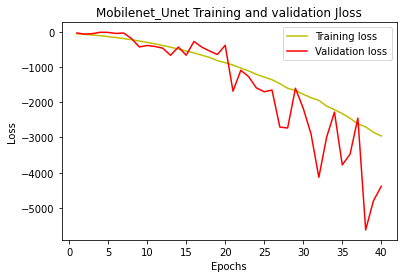

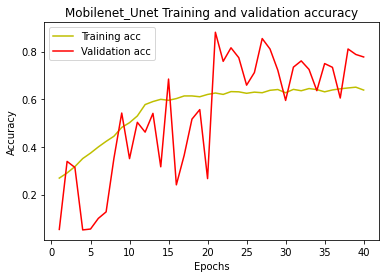

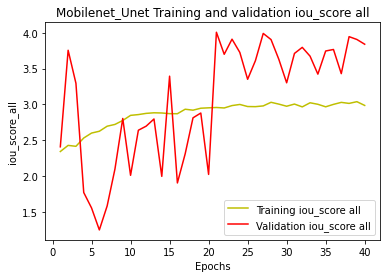

IoU socre is:  0.8410473394520852


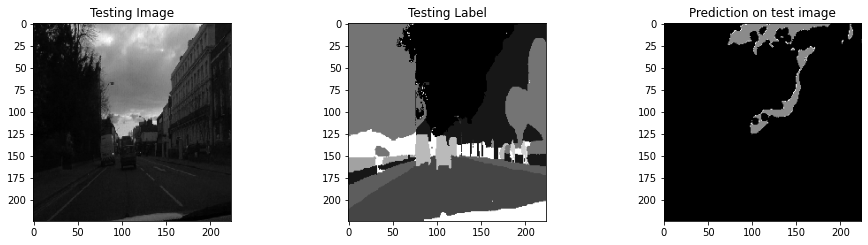

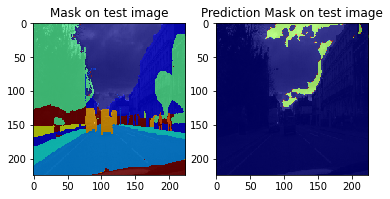

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Mobilenet_Unet Training and validation Jloss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['Accuracy']
val_acc = history.history['val_Accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Mobilenet_Unet Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

iou_scoreall = history.history['iou_score']
val_iou_scoreall = history.history['val_iou_score']

plt.plot(epochs, iou_scoreall, 'y', label='Training iou_score all')
plt.plot(epochs, val_iou_scoreall, 'r', label='Validation iou_score all')
plt.title('Mobilenet_Unet Training and validation iou_score all')
plt.xlabel('Epochs')
plt.ylabel('iou_score_all')
plt.legend()
plt.show()

#IOU
y_pred=model.predict(X_val)
y_pred_thresholded = y_pred > 0.5
#print("validation accuracy",y_pred[1])

intersection = np.logical_and(y_val, y_pred_thresholded)
union = np.logical_or(y_val, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

#Predict on a few images
#model = get_model()
#model.load_weights('mitochondria_50_plus_100_epochs.hdf5') #Trained for 50 epochs and then additional 100

#test_img_number = random.randint(0, len(X_val))
test_img = X_val[3]
ground_truth=y_val[3]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(X_val))

mask = np.argmax(prediction[3], axis=-1)
mask = np.expand_dims(mask, axis=-1)
img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))



plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(img, cmap='gray')

plt.show()
plt.figure()
plt.subplot(1,2,1)
plt.imshow(test_img[:,:,0], 'gray', interpolation='none')
plt.imshow(ground_truth[:,:,0], 'jet', interpolation='none', alpha=0.7)
plt.title('Mask on test image')
plt.subplot(1,2,2)
plt.imshow(test_img[:,:,0], 'gray', interpolation='none')
plt.imshow(img, 'jet', interpolation='none', alpha=0.7)
plt.title('Prediction Mask on test image')
plt.show()

**Poissin matrice:**

 It tells you which explanatory variables have a statistically significant effect on the response variable. In other words, it tells you which X-values work on the Y-value.

**kullback_leibler_divergence**

 Intuitively this measures the how much a given arbitrary distribution is away from the true distribution. If two distributions perfectly match, D_{KL} (p||q) = 0 otherwise it can take values between 0 and ∞. Lower the KL divergence value, the better we have matched the true distribution with our approximation..

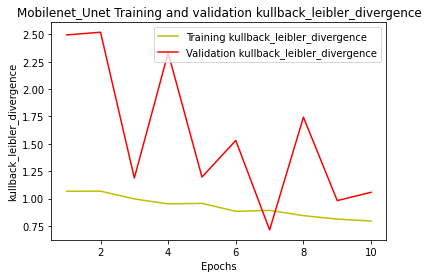

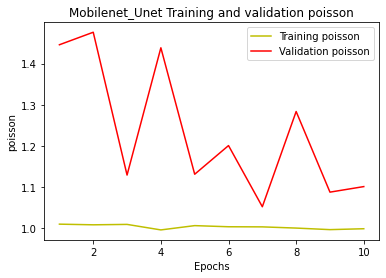

IoU socre is:  0.8103193161669358


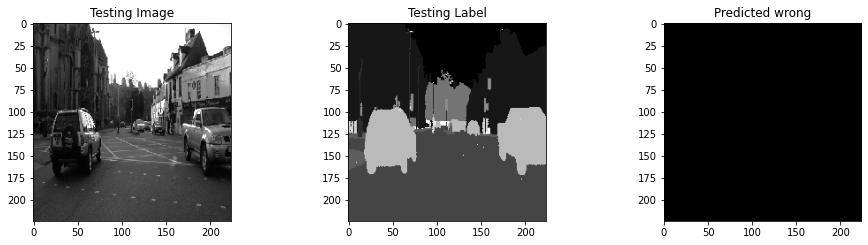

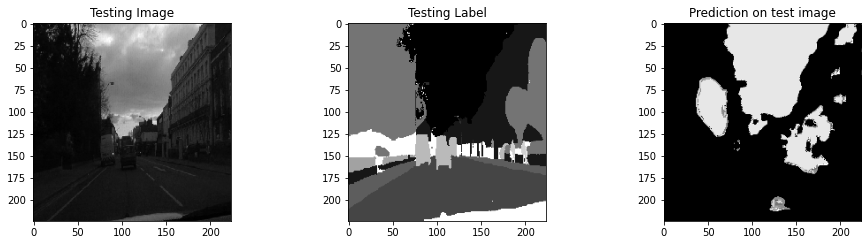

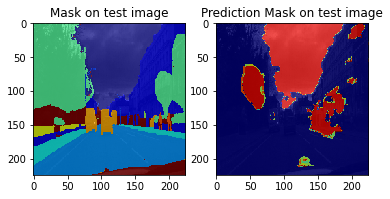

In [32]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['kullback_leibler_divergence']
val_loss = history.history['val_kullback_leibler_divergence']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training kullback_leibler_divergence')
plt.plot(epochs, val_loss, 'r', label='Validation kullback_leibler_divergence')
plt.title('Mobilenet_Unet Training and validation kullback_leibler_divergence')
plt.xlabel('Epochs')
plt.ylabel('kullback_leibler_divergence')
plt.legend()
plt.show()

acc = history.history['poisson']
val_acc = history.history['val_poisson']

plt.plot(epochs, acc, 'y', label='Training poisson')
plt.plot(epochs, val_acc, 'r', label='Validation poisson')
plt.title('Mobilenet_Unet Training and validation poisson')
plt.xlabel('Epochs')
plt.ylabel('poisson')
plt.legend()
plt.show()


#IOU
y_pred=model.predict(X_val)
y_pred_thresholded = y_pred > 0.9
y_pred_thresholdedL = y_pred < 0.45

test_img = X_val[1]
ground_truth=y_val[1]
wrongly= y_pred_thresholdedL[1]
mask = np.argmax(wrongly, axis=-1)
mask = np.expand_dims(mask, axis=-1)
imgw = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Predicted wrong')
plt.imshow(imgw, cmap='gray')


#print("validation accuracy",y_pred[1])

intersection = np.logical_and(y_val, y_pred_thresholded)
union = np.logical_or(y_val, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

#Predict on a few images
#model = get_model()
#model.load_weights('mitochondria_50_plus_100_epochs.hdf5') #Trained for 50 epochs and then additional 100

#test_img_number = random.randint(0, len(X_val))
test_img = X_val[3]
ground_truth=y_val[3]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(X_val))

mask = np.argmax(prediction[3], axis=-1)
mask = np.expand_dims(mask, axis=-1)
img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))



plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(img, cmap='gray')

plt.show()
plt.figure()
plt.subplot(1,2,1)
plt.imshow(test_img[:,:,0], 'gray', interpolation='none')
plt.imshow(ground_truth[:,:,0], 'jet', interpolation='none', alpha=0.7)
plt.title('Mask on test image')
plt.subplot(1,2,2)
plt.imshow(test_img[:,:,0], 'gray', interpolation='none')
plt.imshow(img, 'jet', interpolation='none', alpha=0.7)
plt.title('Prediction Mask on test image')
plt.show()

## LinkNet with MobileNet v2 for Sementic segmentation

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1_pad (ZeroPadding2D)      (None, 225, 225, 3)  0           ['input_7[0][0]']                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['Conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

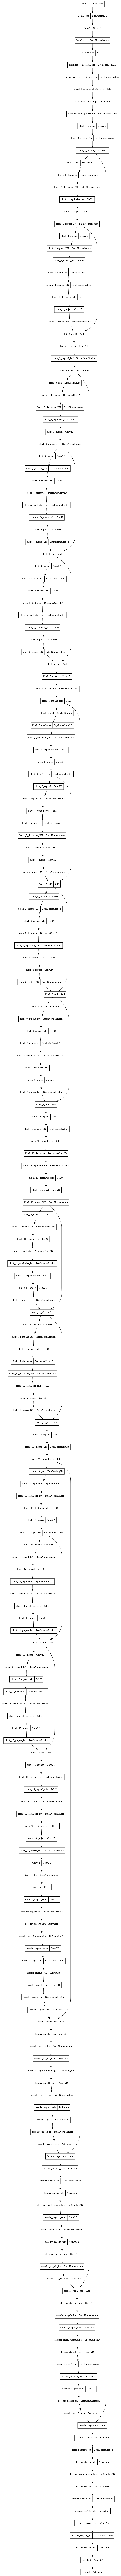

In [48]:
BACKBONE = 'mobilenetv2'
preprocess_input = sm.get_preprocessing(BACKBONE)
keras.backend.set_image_data_format('channels_last')
# define model
model = sm.Linknet(BACKBONE, input_shape=(224, 224, 3), encoder_weights='imagenet', classes=12, activation='sigmoid')
model.summary()
plot_model(model, to_file='/content/drive/MyDrive/Colab Notebooks/A3_Dataset/Linknet_mobilenet_segmentation.png')

### Model Traning

In [25]:
from segmentation_models.metrics import iou_score
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="Adam", loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score,tf.keras.metrics.KLDivergence(name="kullback_leibler_divergence", dtype=None),tf.keras.metrics.Poisson(name="poisson", dtype=None), 'Accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/A3_Dataset/dataset1/City_segmentation42221.h5", save_best_only=True)
]

batch_size = 32
steps_per_epoch = (4)*(len(X_train))//batch_size


# Train the model, doing validation at the end of each epoch.
epochs = 40
history=model.fit(my_generator, epochs=epochs, validation_data=validation_datagen,steps_per_epoch=steps_per_epoch, validation_steps=steps_per_epoch, callbacks=callbacks)

Epoch 1/40
34/34 [==============================] - 40s 1s/step - loss: -15.0266 - iou_score: 2.0917 - kullback_leibler_divergence: 3.0250 - poisson: 1.3520 - Accuracy: 0.0330 - val_loss: -286.7249 - val_iou_score: 4.0816 - val_kullback_leibler_divergence: 0.0236 - val_poisson: 1.0039 - val_Accuracy: 0.8793
Epoch 2/40
34/34 [==============================] - 34s 1s/step - loss: -28.6925 - iou_score: 2.4046 - kullback_leibler_divergence: 2.3321 - poisson: 1.2043 - Accuracy: 0.1211 - val_loss: -651.3253 - val_iou_score: 3.5833 - val_kullback_leibler_divergence: 0.6137 - val_poisson: 1.1376 - val_Accuracy: 0.7937
Epoch 3/40
34/34 [==============================] - 33s 987ms/step - loss: -44.4015 - iou_score: 2.6371 - kullback_leibler_divergence: 1.8955 - poisson: 1.1099 - Accuracy: 0.2051 - val_loss: -441.1624 - val_iou_score: 4.0723 - val_kullback_leibler_divergence: 0.0393 - val_poisson: 1.0095 - val_Accuracy: 0.9593
Epoch 4/40
34/34 [==============================] - 32s 967ms/step - l

In [ ]:
from segmentation_models.metrics import iou_score
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="Adam", loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score,tf.keras.metrics.KLDivergence(name="kullback_leibler_divergence", dtype=None),tf.keras.metrics.Poisson(name="poisson", dtype=None), 'Accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/A3_Dataset/dataset1/City_segmentation42221.h5", save_best_only=True)
]

batch_size = 32
steps_per_epoch = (4)*(len(X_train))//batch_size


# Train the model, doing validation at the end of each epoch.
epochs = 90
history=model.fit(my_generator, epochs=epochs, validation_data=validation_datagen,steps_per_epoch=steps_per_epoch, validation_steps=steps_per_epoch, callbacks=callbacks)

Epoch 1/90
34/34 [==============================] - 41s 1s/step - loss: -2.8576 - iou_score: 1.3797 - kullback_leibler_divergence: 4.6574 - poisson: 1.9243 - Accuracy: 0.0895 - val_loss: -112.8374 - val_iou_score: 3.9522 - val_kullback_leibler_divergence: 0.1140 - val_poisson: 1.0298 - val_Accuracy: 0.1620
Epoch 2/90
34/34 [==============================] - 33s 984ms/step - loss: -15.7903 - iou_score: 2.3400 - kullback_leibler_divergence: 2.3361 - poisson: 1.2251 - Accuracy: 0.1620 - val_loss: -95.2925 - val_iou_score: 4.1190 - val_kullback_leibler_divergence: 0.0038 - val_poisson: 1.0011 - val_Accuracy: 0.7943
Epoch 3/90
34/34 [==============================] - 33s 991ms/step - loss: -32.6725 - iou_score: 2.2866 - kullback_leibler_divergence: 2.6147 - poisson: 1.2509 - Accuracy: 0.1925 - val_loss: -5.5984 - val_iou_score: 2.0039 - val_kullback_leibler_divergence: 2.8195 - val_poisson: 1.7649 - val_Accuracy: 0.0018
Epoch 4/90
34/34 [==============================] - 34s 1s/step - loss:

### Model Analysis

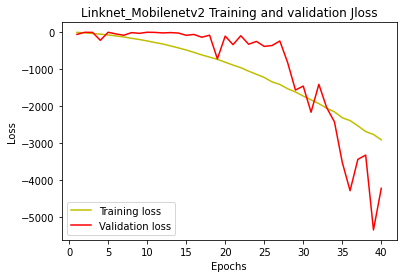

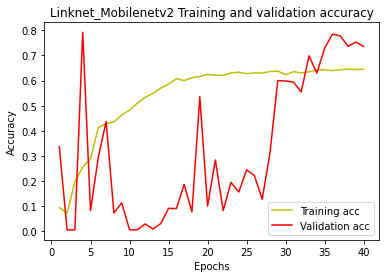

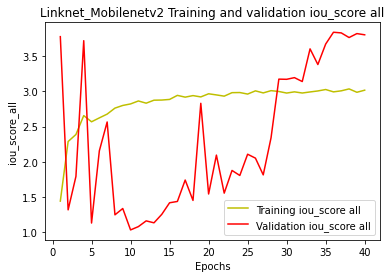

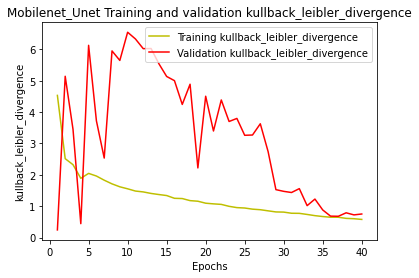

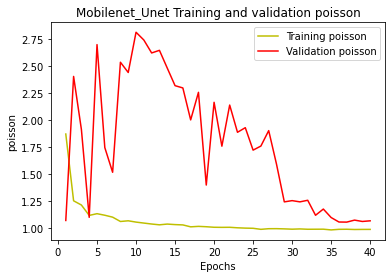

validation accuracy (224, 224, 12)
IoU socre is:  0.8410473394520852
(224, 224)
(224, 224, 1)
(224, 224, 1)


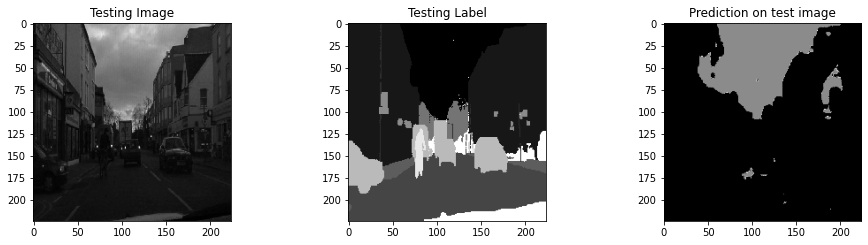

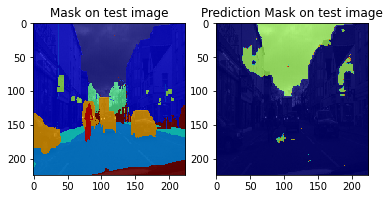

In [44]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Linknet_Mobilenetv2 Training and validation Jloss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['Accuracy']
val_acc = history.history['val_Accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Linknet_Mobilenetv2 Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

iou_scoreall = history.history['iou_score']
val_iou_scoreall = history.history['val_iou_score']

plt.plot(epochs, iou_scoreall, 'y', label='Training iou_score all')
plt.plot(epochs, val_iou_scoreall, 'r', label='Validation iou_score all')
plt.title('Linknet_Mobilenetv2 Training and validation iou_score all')
plt.xlabel('Epochs')
plt.ylabel('iou_score_all')
plt.legend()
plt.show()
loss = history.history['kullback_leibler_divergence']
val_loss = history.history['val_kullback_leibler_divergence']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training kullback_leibler_divergence')
plt.plot(epochs, val_loss, 'r', label='Validation kullback_leibler_divergence')
plt.title('Mobilenet_Unet Training and validation kullback_leibler_divergence')
plt.xlabel('Epochs')
plt.ylabel('kullback_leibler_divergence')
plt.legend()
plt.show()

acc = history.history['poisson']
val_acc = history.history['val_poisson']

plt.plot(epochs, acc, 'y', label='Training poisson')
plt.plot(epochs, val_acc, 'r', label='Validation poisson')
plt.title('Mobilenet_Unet Training and validation poisson')
plt.xlabel('Epochs')
plt.ylabel('poisson')
plt.legend()
plt.show()

#IOU
y_pred=model.predict(X_val)
y_pred_thresholded = y_pred > 0.5
print("validation accuracy",y_pred[1].shape)



intersection = np.logical_and(y_val, y_pred_thresholded)
union = np.logical_or(y_val, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

#Predict on a few images
#model = get_model()
#model.load_weights('mitochondria_50_plus_100_epochs.hdf5') #Trained for 50 epochs and then additional 100

#test_img_number = random.randint(0, len(X_val))
test_img = X_val[2]
ground_truth=y_val[2]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(X_val))

mask = np.argmax(prediction[2], axis=-1)
print(mask.shape)
mask = np.expand_dims(mask, axis=-1)
print(mask.shape)
img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
print(mask.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(img, cmap='gray')

plt.show()
plt.figure()
plt.subplot(1,2,1)
plt.imshow(test_img[:,:,0], 'gray', interpolation='none')
plt.imshow(ground_truth[:,:,0], 'jet', interpolation='none', alpha=0.7)
plt.title('Mask on test image')
plt.subplot(1,2,2)
plt.imshow(test_img[:,:,0], 'gray', interpolation='none')
plt.imshow(img, 'jet', interpolation='none', alpha=0.7)
plt.title('Prediction Mask on test image')
plt.show()

## Not Functional

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
class Evaluator:
    """
    Evaluaion :predict on test data (not submission data from test folder)
    and print reports, plot results etc.
    """
     
    def __init__(self, model, training, X_val, ground_truth):
        self.training = training
        self.X_val = X_val
        # predict the data
        steps=5
        self.ex = model.predict(X_val)
        self.y_pred = np.argmax(self.ex[2], axis=-1)
        self.y_true=ground_truth[2]    
    def print_report(self):
        """
        Predict and evaluate using ground truth from labels
        Test generator did not shuffle 
        and we can use true labels for comparison
        """
        #Print classification report
        print(metrics.classification_report(self.y_true, self.y_pred))
    def plot_roc(self):
        y_pred_keras = model.predict(X_val)
        # Calculate roc
        fpr_keras, tpr_keras, thresholds_keras = roc_curve(self.y_true, self.y_pred)
        auc_keras = auc(fpr_keras, tpr_keras)
        
        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.legend(loc='best')
        plt.show()

# Create evaluator instance
evaluator = Evaluator(model, history, X_val, y_val)

# ROC curve
evaluator.plot_roc()

# Classification report
evaluator.print_report()

258449408/258434480 [==============================] - 7s 0us/step
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 64  1728        ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 112, 112, 64  256         ['stem_conv[0][0]']              
                         

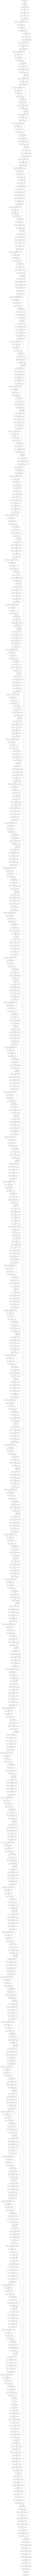

In [45]:
BACKBONE = 'efficientnetb7'
preprocess_input = sm.get_preprocessing(BACKBONE)
keras.backend.set_image_data_format('channels_last')
# define model
model = sm.Linknet(BACKBONE, input_shape=(224, 224, 3), encoder_weights='imagenet', classes=12, activation='sigmoid')
model.summary()
plot_model(model, to_file='/content/drive/MyDrive/Colab Notebooks/A3_Dataset/Linknet_efficientnetb7_segmentation.png')

##EfficentUnet no transfer learning

In [ ]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    
   # x=layers.Rescaling(1.0 / 255)(inputs)
   # x=layers.RandomFlip("horizontal")(x)
   # x=layers.RandomRotation(0.1)(x)
   # x=layers.RandomZoom(0.3)(x)
   


    ### [First half of the network: downsampling inputs] ###
    
    # Entry block

    
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)#(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes,2, activation="sigmoid", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()
img_size=(224,224)
num_classes=12
# Build model
model = get_model(img_size, num_classes)
model.summary()

In [10]:
from segmentation_models.metrics import iou_score

# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="Adam", loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score, 'Accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/A3_Dataset/dataset1/City_segmentation11.h5", save_best_only=True)
]

batch_size = 32
steps_per_epoch = (3)*(len(X_train))//batch_size


# Train the model, doing validation at the end of each epoch.
epochs = 25
history=model.fit(my_generator, epochs=epochs, validation_data=validation_datagen,steps_per_epoch=steps_per_epoch, validation_steps=steps_per_epoch, callbacks=callbacks)

Epoch 1/25
25/25 [==============================] - 45s 1s/step - loss: -9497.6748 - iou_score: 2.9373 - Accuracy: 0.8370 - val_loss: -9953.7764 - val_iou_score: 4.0959 - val_Accuracy: 0.9996
Epoch 2/25
25/25 [==============================] - 35s 1s/step - loss: -2838292.2500 - iou_score: 3.2491 - Accuracy: 0.9990 - val_loss: -3278382.0000 - val_iou_score: 4.1047 - val_Accuracy: 1.0000
Epoch 3/25
25/25 [==============================] - 25s 1s/step - loss: -190490672.0000 - iou_score: 3.1763 - Accuracy: 0.9997 - val_loss: -218336688.0000 - val_iou_score: 4.1239 - val_Accuracy: 1.0000
Epoch 4/25
25/25 [==============================] - 25s 1s/step - loss: -5223170560.0000 - iou_score: 3.2130 - Accuracy: 0.9998 - val_loss: -5669650432.0000 - val_iou_score: 4.1097 - val_Accuracy: 1.0000
Epoch 5/25
25/25 [==============================] - 25s 1s/step - loss: -78773051392.0000 - iou_score: 3.1094 - Accuracy: 1.0000 - val_loss: -96550199296.0000 - val_iou_score: 4.1008 - val_Accuracy: 1.000

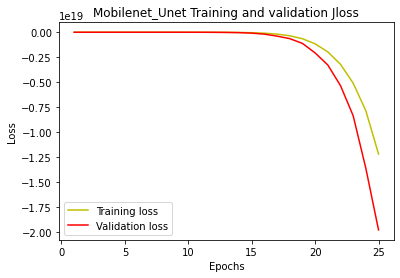

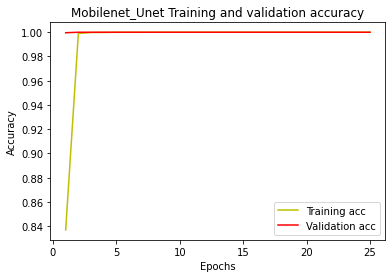

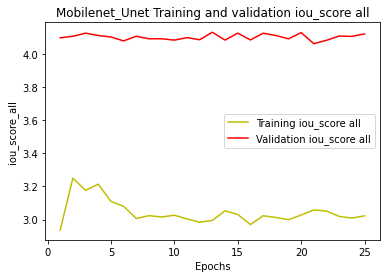

IoU socre is:  0.8410473394520852


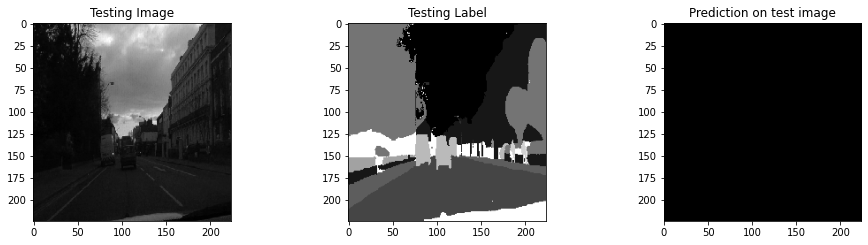

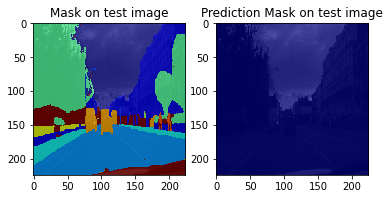

In [11]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Mobilenet_Unet Training and validation Jloss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['Accuracy']
val_acc = history.history['val_Accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Mobilenet_Unet Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

iou_scoreall = history.history['iou_score']
val_iou_scoreall = history.history['val_iou_score']

plt.plot(epochs, iou_scoreall, 'y', label='Training iou_score all')
plt.plot(epochs, val_iou_scoreall, 'r', label='Validation iou_score all')
plt.title('Mobilenet_Unet Training and validation iou_score all')
plt.xlabel('Epochs')
plt.ylabel('iou_score_all')
plt.legend()
plt.show()

#IOU
y_pred=model.predict(X_val)
y_pred_thresholded = y_pred > 0.5
#print("validation accuracy",y_pred[1])

intersection = np.logical_and(y_val, y_pred_thresholded)
union = np.logical_or(y_val, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

#Predict on a few images
#model = get_model()
#model.load_weights('mitochondria_50_plus_100_epochs.hdf5') #Trained for 50 epochs and then additional 100

#test_img_number = random.randint(0, len(X_val))
test_img = X_val[3]
ground_truth=y_val[3]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(X_val))

mask = np.argmax(prediction[3], axis=-1)
mask = np.expand_dims(mask, axis=-1)
img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))



plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(img, cmap='gray')

plt.show()
plt.figure()
plt.subplot(1,2,1)
plt.imshow(test_img[:,:,0], 'gray', interpolation='none')
plt.imshow(ground_truth[:,:,0], 'jet', interpolation='none', alpha=0.7)
plt.title('Mask on test image')
plt.subplot(1,2,2)
plt.imshow(test_img[:,:,0], 'gray', interpolation='none')
plt.imshow(img, 'jet', interpolation='none', alpha=0.7)
plt.title('Prediction Mask on test image')
plt.show()